# Image restoration / segmentation project

## Maxflow - mincut example

maxflow is a Python module for max-flow/min-cut computations. It wraps the C++ maxflow library by Vladimir Kolmogorov, which implements the algorithm described in

An Experimental Comparison of Min-Cut/Max-Flow Algorithms for Energy Minimization in Vision. Yuri Boykov and Vladimir Kolmogorov. TPAMI.

This module aims to simplify the construction of graphs with complex layouts. It provides two Graph classes, Graph[int] and Graph[float], for integer and real data types.

To install, run 

pip install PyMaxFlow

for your python. Here we assume python3, but python2 is also supported


In [20]:
## Once installed, you can use the maxflow package

import maxflow

## Graph example

<img src="graph.png" alt="Graph example" style="width: 200px;"/>

In [17]:
g = maxflow.Graph[int](2, 2)

# Add two (non-terminal) nodes. Get the index to the first one.
nodes = g.add_nodes(2)
# Create two edges (forwards and backwards) with the given capacities.
# The indices of the nodes are always consecutive.
g.add_edge(nodes[0], nodes[1], 1, 2)
# Set the capacities of the terminal edges...
# ...for the first node.
g.add_tedge(nodes[0], 2, 5)
# ...for the second node.
g.add_tedge(nodes[1], 9, 4)

flow = g.maxflow()
print("Maximum flow:", flow)

Maximum flow: 8


In [19]:
print("Segment of the node 0:", g.get_segment(nodes[0]))
print("Segment of the node 1:", g.get_segment(nodes[1]))

Segment of the node 0: 1
Segment of the node 1: 0


### interpretation
The result can be interpreted in the following way:

<img src="graph2.png" alt="Graph result" style="width: 200px;"/>

### Flow network from an image

Flow network can be directly computed from an image, which is very convenient:
http://pmneila.github.io/PyMaxflow/maxflow.html

We use as example a noisy image of the letter A:


<img src="a2.png" alt="Graph result" style="width: 80px;"/>

In [21]:
import numpy as np
import scipy
from scipy.misc import imread
import maxflow

img = imread("a2.png")

/usr/local/Cellar/ipython/7.3.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


### Image restoration

We will restore the image minimizing the energy

$$E(\mathbf{x}) = \sum_i D_i(x_i) + \lambda \sum_{(i,j)\in\mathcal{C}} |x_i - x_j|$$,

where $\mathbf{x} \in \{0,1\}^N$ are the values of the restored image, $N$ is the number of pixels. The unary term $D_i(0)$ (resp $D_i(1)$) is the penalty for assigning the value 0 (resp 1) to the i-th pixel. Each $D_i$ depends on the values of the noisy image, which are denoted as $p_i$:

$D_i(x_i)$ = \begin{cases} p_i & \textrm{if } x_i=0\\ 
255-p_i & \textrm{if } x_i=1 \end{cases}.

Thus, $D_i$ is low when assigning the label 0 to dark pixels or the label 1 to bright pixels, and high otherwise. The value $\lambda$ is the regularization strength. The larger $\lambda$ the smoother the restoration. We set it to 50. This $\lambda$ does not need to be a fixed constant for every pixel, but in this case it is. It may not depend on $\mathbf{x}$.

The maximum flow algorithm is widely used to minimize energy functions of this type. We build a graph which represents the above energy. This graph has as many non-terminal nodes as pixels in the image. The nodes are connected in a grid arrangement, so that the nodes corresponding to neighbor pixels are connected by a forward and a backward edge. The capacities of all non-terminal edges is $\lambda$. The capacities of the edges from the source node are set to $D_i(0)$, and the capacities of the edges to the sink node are $D_i(1)$.

We could build this graph as in the first example. First, we would add all the nodes. Then, we would iterate over the nodes adding the edges properly. However, this is extremely slow in Python, especially when dealing with large images or stacks of images. PyMaxflow provides methods for building some complex graphs with a few calls. In this example we review add_grid_nodes, add_grid_edges, which add edges with a fixed capacity to the grid, and add_grid_tedges, which sets the capacities of the terminal edges for multiple nodes:

In [22]:
# Create the graph.
g = maxflow.Graph[int]()
# Add the nodes. nodeids has the identifiers of the nodes in the grid.
nodeids = g.add_grid_nodes(img.shape)
# Add non-terminal edges with the same capacity.
g.add_grid_edges(nodeids, 50)
# Add the terminal edges. The image pixels are the capacities
# of the edges from the source node. The inverted image pixels
# are the capacities of the edges to the sink node.
g.add_grid_tedges(nodeids, img, 255-img)

Finally, we perform the maxflow computation and get the results:

In [23]:
# Find the maximum flow.
g.maxflow()
# Get the segments of the nodes in the grid.
sgm = g.get_grid_segments(nodeids)

The method get_grid_segments returns an array with the same shape than nodeids. It is almost equivalent to calling get_segment once for each node in nodeids, but much faster. For the i-th cell, the array stores False if the i-th node belongs to the source segment (i.e., the corresponding pixel has the label 1) and True if the node belongs to the sink segment (i.e., the corresponding pixel has the label 0). We now get the labels for each pixel:

<IPython.core.display.Javascript object>


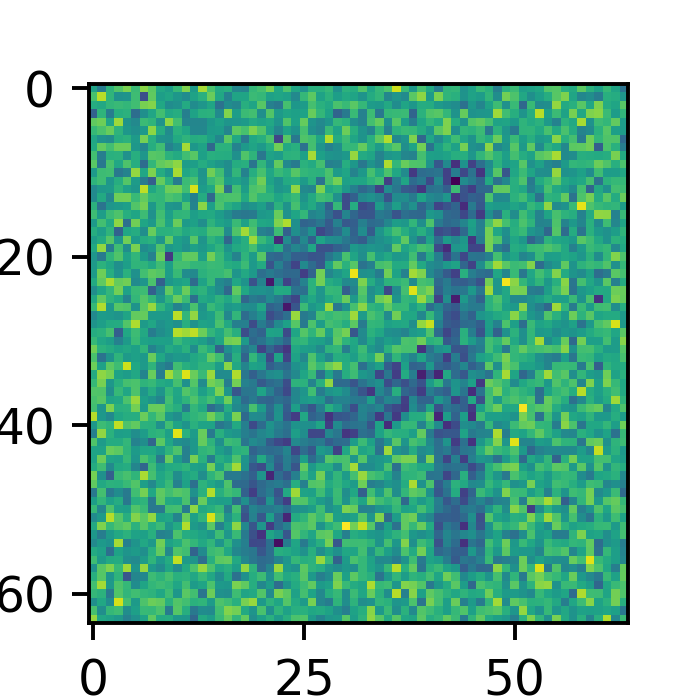

<IPython.core.display.Javascript object>


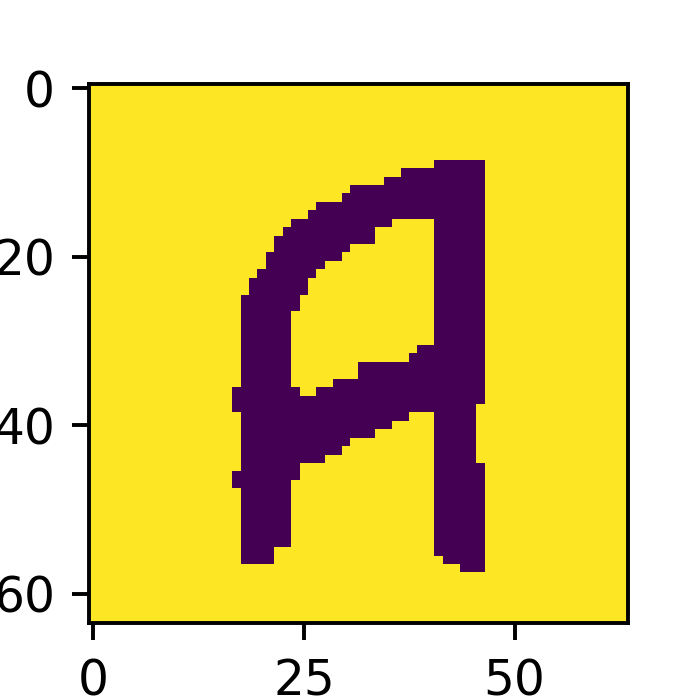

In [31]:
%matplotlib notebook
# The labels should be 1 where sgm is False and 0 otherwise.
img2 = np.int_(np.logical_not(sgm))
# Show the result.
from matplotlib import pyplot as plt

plt.figure(figsize=(2,2))
plt.imshow(img)
plt.figure(figsize=(2,2))
plt.imshow(img2)
plt.show()

### More complex layouts

The method add_grid_edges is a powerful tool to create complex layouts. The first argument, nodeids is an array of node identifiers with the shape of the grid of nodes where the edges will be added. The edges to add and their final capacities are computed using the arguments weights and structure.

weights is an array and its shape must be broadcastable to the shape of nodeids. Thus every node will have a associated weight. structure is an array with the same dimensions as nodeids and with an odd shape. It defines the local neighborhood of every node.

Given a node, the structure array is centered on it. Edges are created from that node to the nodes of its neighborhood corresponding to nonzero entries of structure. The capacity of the new edge will be the product of the weight of the initial node and the corresponding value in structure. Additionally, a reverse edge with the same capacity will be added if the argument symmetric is True (by default).

Therefore, the weights argument allows to define an inhomogeneous graph, with different capacities in different areas of the grid. On the other hand, besides defining the local neighborhood of each node, structure enables anisotropic edges, with different capacities depending on their orientation.

### Extension example on github

The github of the PyMaxFlow package is here: https://github.com/pmneila/PyMaxflow

The file examples/layout_examples.py and the documentation of maxflow.GraphInt.add_grid_edges() contain several different layouts than can be created with add_grid_edges. A more involved example is in examples/layout_example2.py, where a complex graph is created using several calls to maxflow.GraphInt.add_grid_edges() and maxflow.GraphInt.add_grid_tedges().